In [32]:
import psycopg2 as ps
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

con = ps.connect("dbname='seedb' user='' host='localhost' password=''")
cur = con.cursor()

In [33]:
# KL-Divergence(target, reference)
def kl_divergence(target_val, reference_val):
    tgt = target_val.reshape(-1)
    ref = reference_val.reshape(-1)

    if np.sum(tgt) > 0 and np.sum(ref) > 0:
        tgt_prob = tgt / np.sum(tgt)
        ref_prob = ref / np.sum(ref)

        return -np.sum([qi * np.log(pi/qi) for qi, pi in zip(tgt_prob, ref_prob) if pi > 0 and qi > 0])
    else:
        return -0.

In [34]:
def visualize(target_data, ref_data, view_tuple):
    n_groups = len(target_data)
    group_by, measure, function = view_tuple

    means_target = target_data.values()
    means_ref = ref_data.values()

    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(index, means_target, bar_width,
                     alpha=opacity,
                     color='b',
                     label='married')

    rects2 = plt.bar(index + bar_width, means_ref, bar_width,
                     alpha=opacity,
                     color='g',
                     label='unmarried')

    plt.xlabel('{}'.format(group_by))
    plt.ylabel('{}({})'.format(function, measure))
    plt.xticks(index + bar_width, target_data.keys(), rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [35]:
functions = {"count", "sum", "avg", "min", "max"}
attributes = {"workclass", "education", "occupation", "relationship", "race", "sex", "native_country", "economic_indicator"}
measurements = {"age", "fnlwgt", "hours_per_week", "capital_gain", "capital_loss"}

views = {}

count = 0
for attribute in attributes:
    for function in functions:
        for measurement in measurements:
            view = (function, measurement, attribute)
            views[count] = view
            count += 1

print('Total number of views:', len(views))
# print(views)

Total number of views: 200


SELECT native_country, max(capital_gain) FROM married GROUP BY native_country;
SELECT native_country, max(capital_gain) FROM unmarried GROUP BY native_country;


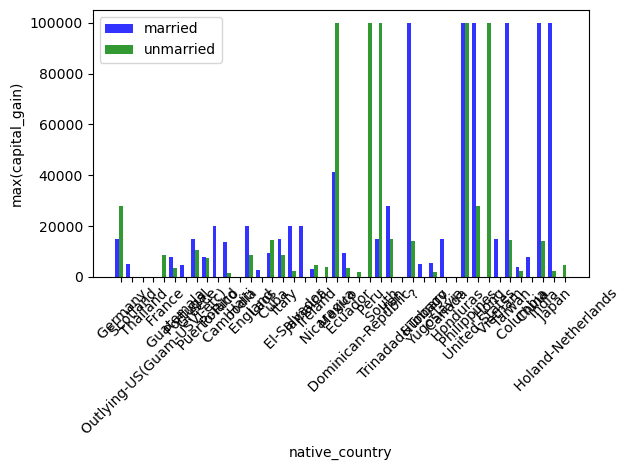

SELECT native_country, avg(capital_gain) FROM married GROUP BY native_country;
SELECT native_country, avg(capital_gain) FROM unmarried GROUP BY native_country;


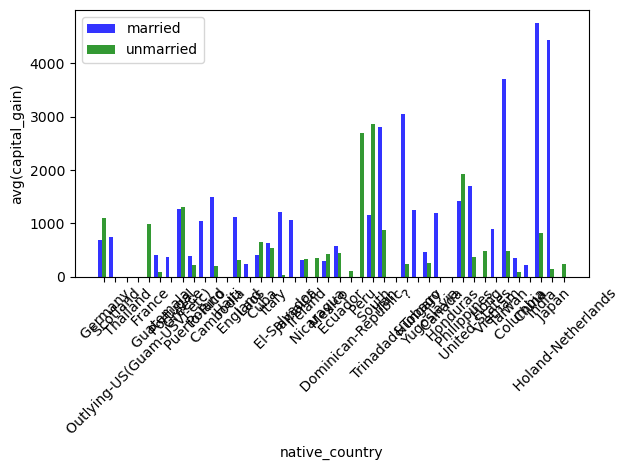

SELECT workclass, min(hours_per_week) FROM married GROUP BY workclass;
SELECT workclass, min(hours_per_week) FROM unmarried GROUP BY workclass;


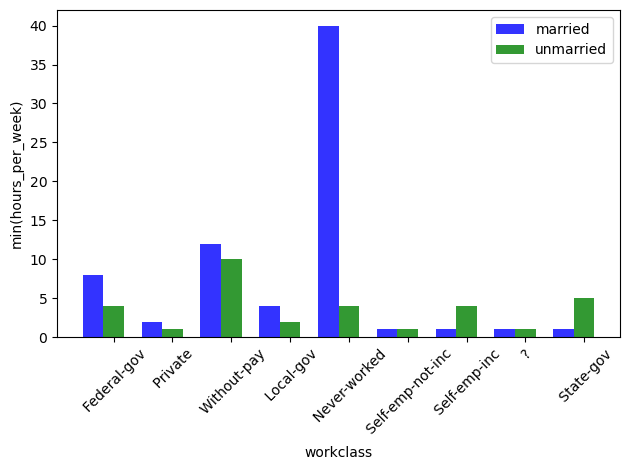

SELECT economic_indicator, sum(capital_loss) FROM married GROUP BY economic_indicator;
SELECT economic_indicator, sum(capital_loss) FROM unmarried GROUP BY economic_indicator;


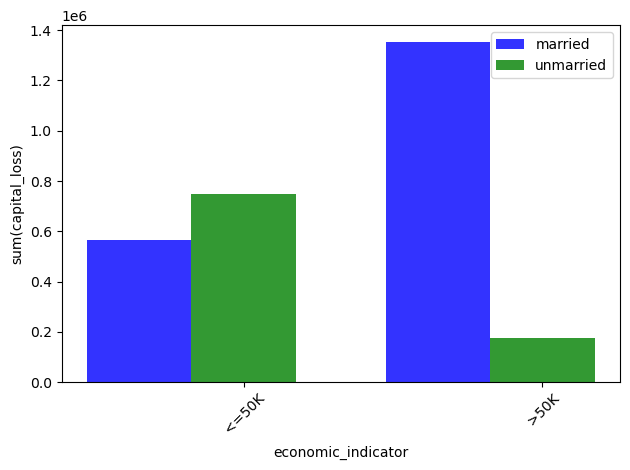

SELECT race, avg(capital_gain) FROM married GROUP BY race;
SELECT race, avg(capital_gain) FROM unmarried GROUP BY race;


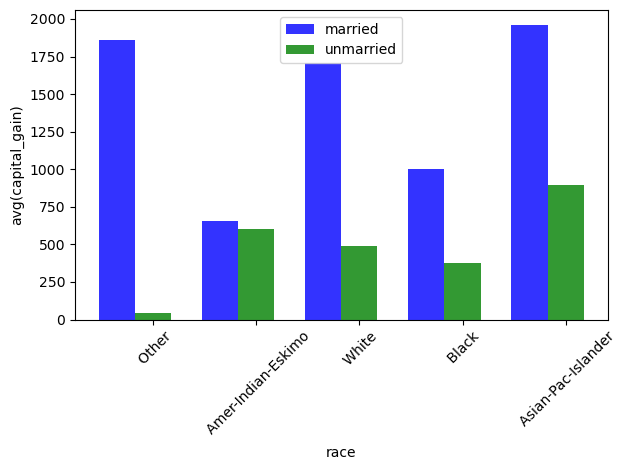

In [44]:
def sharing_based_query(views, tables):
    select_a_str, select_m_str, group_by_str = [], [], []
    for i, (f, m, a) in views.items():
        select_a_str.append(f"{a}")
        select_m_str.append(f"{f}({m}) as v{i}")
        group_by_str.append(f"({a})")

    select_a_str = ', '.join(set(select_a_str))
    select_m_str = ', '.join(select_m_str)
    group_by_str = ', '.join(set(group_by_str))

    data = []
    for table in tables:
        query = f"select {select_a_str}, {select_m_str} from {table} group by grouping sets ({group_by_str});"
        cur.execute(query)
        data.append(cur.fetchall())
    cols = [desc[0] for desc in cur.description]
    return data, cols


tgt_df = pd.DataFrame(data[0], columns=cols)
ref_df = pd.DataFrame(data[1], columns=cols)
view_scores = {}
for vid, (f, m, a) in views.items():
    tgt = tgt_df.loc[tgt_df[a].notnull(), [a, 'v{}'.format(vid)]]    
    ref = ref_df.loc[ref_df[a].notnull(), [a, 'v{}'.format(vid)]]    
    tmp = tgt.join(ref.set_index(a), on=a, how="inner", lsuffix='_tgt', rsuffix='_ref')    
    tgt_val = tmp['v{}_tgt'.format(vid)].values    
    ref_val = tmp['v{}_ref'.format(vid)].values    
    score = kl_divergence(tgt_val, ref_val)    
    view_scores[vid] = score
views_ranking = sorted(view_scores.items(), key=lambda x: x[1], reverse=True)


def top_k_views(ranking, k):
    for vid in ranking[:k]:
        f, m, a = views[vid]

        query = "SELECT {}, {}({}) FROM married GROUP BY {};".format(a, f, m, a)
        print(query)
        cur.execute(query)
        tgt_rows = cur.fetchall()

        query = "SELECT {}, {}({}) FROM unmarried GROUP BY {};".format(a, f, m, a)
        print(query)
        cur.execute(query)
        ref_rows = cur.fetchall()

        tgt_dict = dict(tgt_rows)
        ref_dict = dict(ref_rows)

        for k in tgt_dict.keys():
            if k not in ref_dict:
                ref_dict[k] = 0

        for k in ref_dict.keys():
            if k not in tgt_dict:
                tgt_dict[k] = 0

        visualize(tgt_dict, ref_dict, (a, m, f))

K = 5
top_k_views([r[0] for r in views_ranking], K)

Total number of pruned views: 2.
SELECT native_country, max(capital_gain) FROM married GROUP BY native_country;
SELECT native_country, max(capital_gain) FROM unmarried GROUP BY native_country;


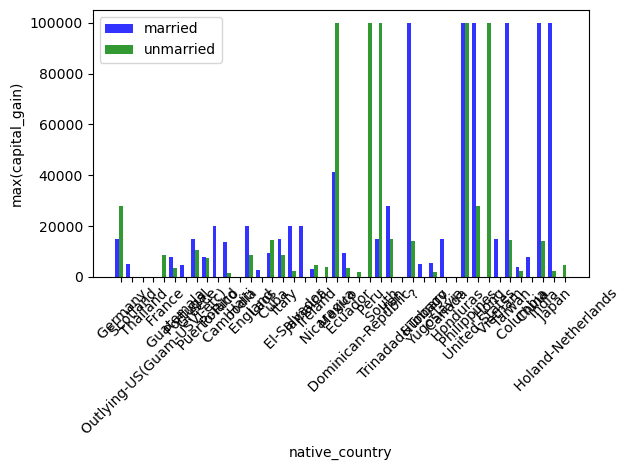

SELECT native_country, avg(capital_gain) FROM married GROUP BY native_country;
SELECT native_country, avg(capital_gain) FROM unmarried GROUP BY native_country;


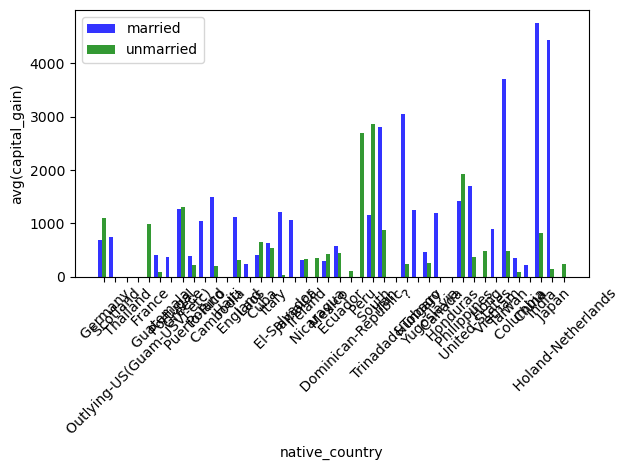

SELECT workclass, min(hours_per_week) FROM married GROUP BY workclass;
SELECT workclass, min(hours_per_week) FROM unmarried GROUP BY workclass;


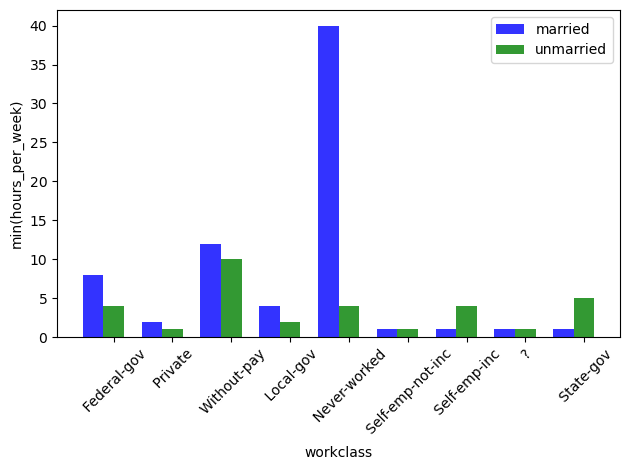

SELECT economic_indicator, sum(capital_loss) FROM married GROUP BY economic_indicator;
SELECT economic_indicator, sum(capital_loss) FROM unmarried GROUP BY economic_indicator;


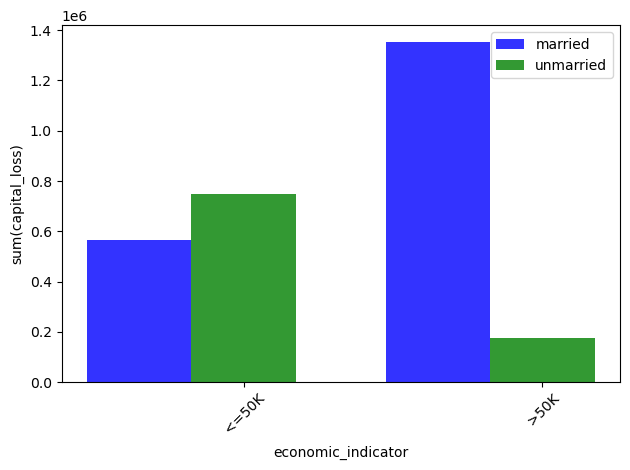

SELECT race, avg(capital_gain) FROM married GROUP BY race;
SELECT race, avg(capital_gain) FROM unmarried GROUP BY race;


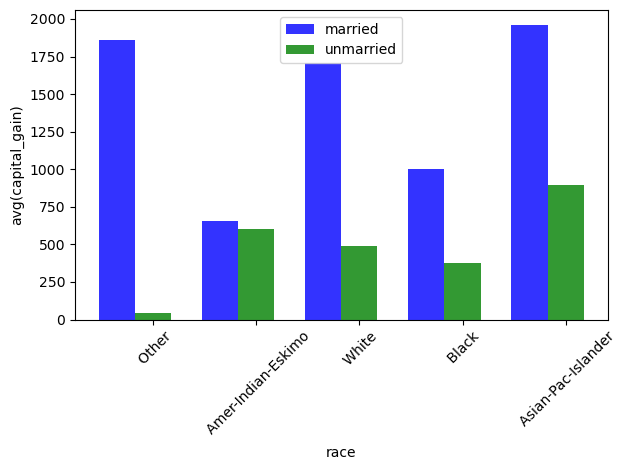

In [43]:
K = 5

view_scores = {k: [] for k, v in views.items()}
current_views = {k: v for k, v in views.items()}

delta = 0.05

for i in range(n_phases):
    tables = ['married', 'unmarried']
    data, cols = sharing_based_query(views, tables)
    
    tgt_df = pd.DataFrame(data[0], columns=cols)
    ref_df = pd.DataFrame(data[1], columns=cols)
    
    for vid, (f, m, a) in current_views.items():
        tgt = tgt_df.loc[tgt_df[a].notnull(), [a, 'v{}'.format(vid)]]
        ref = ref_df.loc[ref_df[a].notnull(), [a, 'v{}'.format(vid)]]
        tmp = tgt.join(ref.set_index(a), on=a, how="inner", lsuffix='_tgt', rsuffix='_ref')

        tgt_val = tmp['v{}_tgt'.format(vid)].values
        ref_val = tmp['v{}_ref'.format(vid)].values
        score = kl_divergence(tgt_val, ref_val)
        view_scores[vid].append(score)
        
    if i > 0:
        m, N = i+1, n_phases
        eps = np.sqrt((0.5/m)*(1-((m-1)/N))*(2*np.log(np.log(m))+np.log((np.pi**2)/(3*delta))))

        current_view_scores = [(k, v) for k, v in view_scores.items() if k in current_views]
        views_ranking = sorted(current_view_scores, key=lambda x: np.mean(x[1]), reverse=True)
        top_k_smallest_lower_bound = np.mean(views_ranking[K][1]) - eps

        for k, v in view_scores.items():
            if k in current_views and np.mean(v) + eps < top_k_smallest_lower_bound:
                del current_views[k]
            
print('Total number of pruned views: {}.'.format(len(views)-len(current_views)))
top_k_views([r[0] for r in views_ranking], K)